# Setup

In [19]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from functools import partial
import numpy as np
import jax, jax.numpy as jp, jax.tree_util as tu, jax.random as rax
import flax, flax.linen as nn, flax.serialization, flax.struct as struct
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

backstop = jax.lax.stop_gradient
deepmap = tu.tree_map

def subplots(things, subplot_wh_hint=(8, 8), **kwargs):
  m, n = len(things), max(map(len, things))
  sw, sh = subplot_wh_hint
  size = jp.array([sw * n, sh * m])
  # guard against accidentally huge figures
  while np.prod(size) > 32 ** 2:
    size = size // 2
  fig, axes = plt.subplots(m, n, figsize=tuple(size), squeeze=False, **kwargs)
  for i, row in enumerate(things):
    for j, spec in enumerate(row):
      if callable(spec):
        plotter, *args = spec,
      else:
        plotter, *args = spec
      plotter(axes[i, j], *args)
  return fig

def logspacedindices(xs): # [*0:10:1, *10:100:10, *100:1000:100, ... -1]
  xs = list(xs)
  ys = [0]
  n = len(str(len(xs))) # intlog10
  for i in range(n):
    ys.extend(np.arange(1, 10) * 10 ** i)
  for y in ys:
    if y < len(xs) - 1: # exclude last element of xs here
      yield y
  yield len(xs) - 1 # always include last element of xs, exactly once

assert list(logspacedindices(range(303))) == [*range(10), *range(10, 100, 10), 100, 200, 300, 302]

In [21]:
@struct.dataclass
class Adam:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta1: float = struct.field(pytree_node=False, default=0.9)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  moment1: "Any" = None
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment1 = deepmap(jp.zeros_like, params)
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment1=moment1, moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    moment1 = deepmap(lambda m, dx: m + (1-self.beta1)*(dx-m), self.moment1, grad)
    moment2 = deepmap(lambda m, dx: m + (1-self.beta2)*(dx**2-m), self.moment2, grad)
    n = self.n + 1
    dbmoment1 = deepmap(lambda m: m/(1-self.beta1**n), moment1)
    dbmoment2 = deepmap(lambda m: m/(1-self.beta2**n), moment2)
    step = deepmap(lambda dm1, dm2: self.lr*(dm1/(self.eps+dm2**0.5)),
                   dbmoment1, dbmoment2)
    new_self = self.replace(moment1=moment1, moment2=moment2, n=n)
    return new_self, step

@struct.dataclass
class Sga:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  @classmethod
  def make_for(cls, params, **hp): return cls(**hp)
  def __call__(self, params, grad): return self, grad

def huber(delta, threshold=1):
  delta = jp.abs(delta)
  return jp.where(delta <= threshold,
                  delta ** 2 / 2,
                  threshold * delta - threshold ** 2 / 2)

def qr_loss(xs, ys):
  [n] = xs.shape
  mid = (jp.arange(n) + 0.5) / n  # quantile midpoints
  dq = ys[None, :] - xs[:, None]
  loss = jp.abs(mid[:, None] - (dq<0)) * huber(dq)
  return loss.sum() / n

# Game definition

In [22]:
def f(z):
  assert z.shape == (2,)
  x, y = z; sx, sy = jax.nn.sigmoid(z)
  return -(4 * jp.array([sx*(1-2*sy), sy*(1-2*sx)])
           + ((x*y)**2 + (x**2-y**2)**2) / 10000)

def simgrad(f): # simultaneous gradients
  return lambda z: jp.diag(jax.jacrev(f)(z))

def get_step_fn(grad_fn):
  @jax.jit
  def step_fn(optimizer, x):
    dx = grad_fn(x)
    optimizer, dx = optimizer(x, dx)
    x = deepmap(lambda x, dx: x+dx, x, dx)
    return optimizer, x
  return step_fn

def train_fromscratch(grad_fn, lr=1., batch_size=16, num_steps=200, seed=1):
  x = (rax.uniform(rax.PRNGKey(seed), shape=[batch_size, 2]) * 2 - 1) * 8
  return train_from(grad_fn, x, lr=lr, num_steps=num_steps)
def train_from(grad_fn, x, lr=1., num_steps=200):
  optimizer = jax.vmap(partial(Sga.make_for, lr=lr))(x)
  step_fn = get_step_fn(grad_fn)
  xs = [x]
  for _ in range(num_steps):
    optimizer, x = jax.vmap(step_fn)(optimizer, x)
    xs.append(x)
  return np.stack(xs, axis=1) # [batch, time, players]


Text(0.5, 0.92, 'player 2 objective')

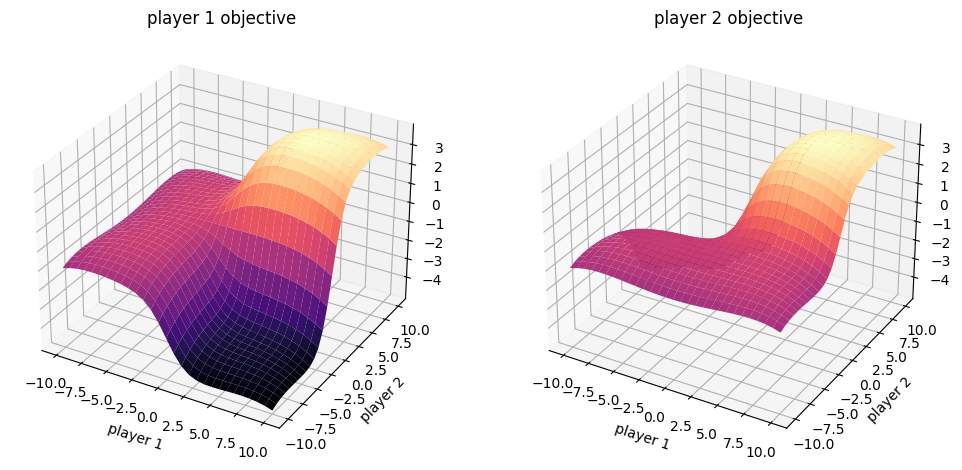

In [23]:
xs = ys = np.linspace(-10, 10, 29)
grid_points = np.stack(np.meshgrid(xs, ys, indexing="ij"), axis=-1)  # [29, 29, 2]

grid_fs = jax.vmap(jax.vmap(f))(grid_points)
goodx,badx = train_from(simgrad(f), jp.array([[5.,5.],[-5.,-5.]]))[:,-1]

example_points = grid_points[::6,::6].reshape([-1,2])
example_points = example_points + rax.normal(rax.PRNGKey(3), shape=example_points.shape)
naive_trails = train_from(simgrad(f), example_points)
naive_fs = jax.vmap(jax.vmap(f))(naive_trails)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(grid_points[...,0],grid_points[...,1],grid_fs[..., 0], cmap="magma")
ax.set_xlabel("player 1");ax.set_ylabel("player 2");ax.set_title("player 1 objective")
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(grid_points[...,0],grid_points[...,1],grid_fs[..., 1], cmap="magma")
ax.set_xlabel("player 1");ax.set_ylabel("player 2");ax.set_title("player 2 objective")


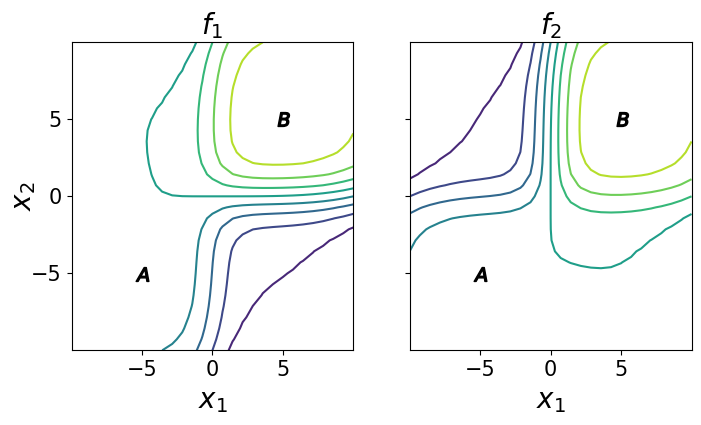

In [24]:
def plot_objective(ax, player):
  ax.contour(grid_points[..., 0],grid_points[..., 1],grid_fs[...,player], cmap="viridis", levels=10)
  ax.scatter(*goodx[:,None], c="k", marker="$B$", s=100)
  ax.scatter(*badx[:,None], c="k", marker="$A$", s=100)
  extent = 10
  ax.set_xlim((-extent,+extent)); ax.set_ylim((-extent,+extent))
  ax.set_xticks([-5,0,5]); ax.set_yticks([-5,0,5])
  ax.tick_params(labelsize=15)
  ax.set_xlabel("$x_1$", fontsize=20, labelpad=5)
  if player == 0:
    ax.set_ylabel("$x_2$", fontsize=20, labelpad=-5)
  ax.set_title(f"$f_{player+1}$", fontsize=20)

subplots([[partial(plot_objective, player=i) for i in range(2)]],
         subplot_wh_hint=(4, 4), sharex=True, sharey=True)
pass

# LOLA

In [25]:
def f_lola(x, alpha=1.):  # LOLA-DiCE variant
  x_extra = x + alpha*simgrad(f)(x)
  assert x.shape == (2,)
  return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
  ])

def f_lola_taylor(x, alpha=1.):  # original LOLA variant
  fprime = jax.jacrev(f)(x)
  g = jp.diag(fprime)
  fprime_offdiag = (1-jp.eye(fprime.shape[0])) * fprime
  return f(x) + alpha*fprime_offdiag@g

def f_hola(x, alpha=1., n=1):  # higher-order LOLA (no taylor approximation)
  if n <= 0:
    return f(x)
  x_extra = x + alpha * simgrad(partial(f_hola, alpha=alpha, n=n-1))(x)
  return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
  ])

# Meta-Value learning



In [26]:
class ResidualBlock(nn.Module):
  @nn.compact
  def __call__(self, x):
    size = x.shape[-1]
    z = nn.gelu(nn.Dense(size, name="X")(x))
    y = nn.Dense(size, name=f"H")(z)
    gate = nn.sigmoid(self.param("G", nn.initializers.zeros, [z.shape[-1]]))
    return gate*x + (1-gate)*y

class VHatModule(nn.Module):
  size: int = 64
  quantiles: int = 1
  @nn.compact
  def __call__(self, x, gamma):
    assert x.shape == (2,) # two players, a scalar policy each
    assert gamma.shape == (2,)
    x = x/10
    h = jp.stack([x,gamma], axis=-1) # [players, features]
    h = nn.gelu(nn.Dense(self.size, name="L0")(h))
    h = ResidualBlock(name="R0")(h)
    h = nn.gelu(nn.Dense(self.size, name="L1")(h))
    h = jp.concatenate([h, h[::-1]], axis=-1) # add in opponent features
    h = nn.gelu(nn.Dense(self.size, name="L2")(h))
    h = ResidualBlock(name="R1")(h)
    h = nn.tanh(nn.Dense(self.size, name="L3")(h))
    y = nn.Dense(self.quantiles, name="output")(h)
    return y

@struct.dataclass
class VHat:
  params: "Any"
  module: "Module" = struct.field(pytree_node=False)
  def __call__(self, x, gamma):
    quantiles = self.quantiles(x, gamma)
    return quantiles.mean(axis=-1)
  def quantiles(self, x, gamma):
    return self.module.apply(dict(params=self.params), x, gamma)
  @classmethod
  def init(cls, module, rng):
    params = module.init(rng, jp.zeros([2], dtype="float32"), jp.zeros([2], dtype="float32"))["params"]
    return cls(params=params, module=module)
  def bind_gamma(self, gamma):
    return partial(self, gamma=jp.full([2], gamma, dtype="float32"))

The cell below will train VHat. This takes about a minute on a GPU.

In [27]:
def vhat_loss_fn(vhat, xs, gamma):
  T, P = xs.shape
  assert gamma.shape == (P,)
  fs = jax.vmap(f)(xs)
  vs = jax.vmap(vhat.quantiles, in_axes=(0,None))(xs, gamma) # across time
  tvs = vs if True else backstop(vs)
  _,_,Q = vs.shape
  assert vs.shape == (T,P,Q)
  predictions = vs[:-1]
  targets = (1-gamma[:,None])*fs[:-1,:,None] + gamma[:,None]*tvs[1:,:,:]
  if Q == 1:
    losses = huber(targets-predictions)
  else:
    losses = jax.vmap(jax.vmap(qr_loss))(predictions, targets) # across time, player
  return losses.mean()

def do_train_vhat(lr=1e-3, alpha=1., T=50, seed=2, batch_size=128):
  train_rng,init_rng = rax.split(rax.PRNGKey(seed))
  vhat = VHat.init(VHatModule(quantiles=16), init_rng)
  optimizer = Adam.make_for(vhat, lr=lr)
  otrace = [vhat]; itraces = []; losses = []

  @jax.jit
  def update_vhat(optimizer, vhat, xs, gammas):
    def loss_fn(vhat):
      losses = jax.vmap(partial(vhat_loss_fn, vhat))(xs, gammas)
      return losses.mean()
    loss, dvhat = jax.value_and_grad(loss_fn)(vhat)
    optimizer, dvhat = optimizer(vhat, dvhat)
    vhat = deepmap(lambda x,dx: x-dx, vhat,dvhat)
    return optimizer, vhat, loss
  @jax.jit
  def update_x(vhat, x, gamma):
    dx = simgrad(partial(vhat, gamma=gamma))(x)
    return x+alpha*dx
  for i in range(1001):
    train_rng,gamma_rng,inner_init_rng = rax.split(train_rng,3)
    x = (rax.uniform(inner_init_rng, shape=[batch_size,2]) * 2 - 1) * 8
    gammas = rax.beta(gamma_rng, 0.5, 0.5, shape=[batch_size,2])  # arcsine
    xs = [x]
    for _ in range(T):
      x = jax.vmap(update_x, in_axes=(None,0,0))(vhat, x, gammas)
      xs.append(x)
    xs = np.stack(xs, axis=1) # [batch, time, players]
    optimizer, vhat, loss = update_vhat(optimizer, vhat, xs, gammas)
    otrace.append(vhat); itraces.append(xs); losses.append(loss)
  return dict(trace=otrace, itraces=itraces, losses=losses)

vhat_trace = do_train_vhat()
final_vhat = vhat_trace["trace"][-1]
def f_vhat(x, gamma=0.):
  return final_vhat.bind_gamma(gamma)(x)

In [ ]:
def plot_training_process(vhat_trace, gamma=0.99):
  def plot_vhat(ot, ax, time, player):
    vhat = ot["trace"][time].bind_gamma(gamma)
    vs = jax.vmap(jax.vmap(vhat))(grid_points)
    ax.contourf(grid_points[..., 0], grid_points[..., 1], vs[..., player], cmap="magma", levels=10)
    ax.set_title(f"T {time} P {player}")
    ax.set_axis_off()
  def plot_trails(ot, ax, time):
    vhat = ot["trace"][time].bind_gamma(gamma)
    trace = train_fromscratch(simgrad(vhat))
    ax.plot(trace[..., 0].T, trace[..., 1].T, linewidth=2)
    ax.set_xlim((-10,10)); ax.set_ylim((-10,10))

  plt.figure()
  plt.plot(vhat_trace["losses"])
  subplots([[partial(plot_vhat, vhat_trace, time=time, player=0),
             partial(plot_vhat, vhat_trace, time=time, player=1),
             partial(plot_trails, vhat_trace, time=time)]
            for time in logspacedindices(vhat_trace["itraces"])],
          subplot_wh_hint=(4, 4))
plot_training_process(vhat_trace)

pass

# COLA

COLA is pretty similar to Meta-Value learning structurally -- since parameters are scalar, the gradient has the same shape as the objective. So we can use the same model definition. Note that gamma is now the extrapolation step size (aka alpha).

This cell trains COLA and takes about a minute on a GPU.

In [29]:
def cola_loss_fn(ghat, x, gamma):
  [P] = x.shape
  assert gamma.shape == (P,)
  # loss is ||ghat(x) - grad_x f(x + gamma ghat(x))||
  predictions = ghat(x, gamma)
  def f_cola(x):
    x_extra = x+gamma*ghat(x,gamma)
    assert x.shape == (2,)
    return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
    ])
  targets = simgrad(f_cola)(x)
  losses = huber(targets-predictions)
  return losses.mean()

def do_train_cola(lr=1e-3, seed=1, batch_size=256):
  train_rng,init_rng = rax.split(rax.PRNGKey(seed))
  ghat = VHat.init(VHatModule(quantiles=1), init_rng)
  optimizer = Adam.make_for(ghat, lr=lr)
  otrace = [ghat]; losses = []
  @jax.jit
  def update_ghat(optimizer, ghat, xs, gammas):
    def loss_fn(ghat):
      losses = jax.vmap(partial(cola_loss_fn, ghat))(xs, gammas)
      return losses.mean()
    loss, dghat = jax.value_and_grad(loss_fn)(ghat)
    optimizer, dghat = optimizer(ghat, dghat)
    ghat = deepmap(lambda x, dx: x-dx, ghat, dghat)
    return optimizer, ghat, loss
  for i in range(10001):
    train_rng,gamma_rng,inner_init_rng = rax.split(train_rng,3)
    xs = (rax.uniform(inner_init_rng, shape=[batch_size,2]) * 2 - 1) * 8
    gammas = 10*rax.uniform(gamma_rng, shape=[batch_size,2])
    optimizer, ghat, loss = update_ghat(optimizer, ghat, xs, gammas)
    otrace.append(ghat); losses.append(loss)
  return dict(trace=otrace, losses=losses)

cola_trace = do_train_cola()
final_cola = cola_trace["trace"][-1]
def g_cola(x, gamma=1.):
  return final_cola.bind_gamma(gamma)(x)

In [ ]:
def plot_cola_training_process(cola_trace, gamma=1.0):
  def plot_trails(ot, ax, time):
    ghat = ot["trace"][time].bind_gamma(gamma)
    trace = train_fromscratch(ghat)
    ax.plot(trace[..., 0].T, trace[..., 1].T, linewidth=2)
    ax.set_xlim((-10,10)); ax.set_ylim((-10,10))
    ax.set_title(str(time))

  plt.figure()
  plt.plot(cola_trace["losses"])
  subplots([[partial(plot_trails, cola_trace, time=time)]
            for time in logspacedindices(cola_trace["trace"])],
          subplot_wh_hint=(4, 4))
plot_cola_training_process(cola_trace)

pass

# Comparison of algorithms

In [31]:
def compute_grid_endpoints(grad_fn, T=200):
  trace = train_from(grad_fn, grid_points.reshape([-1, *grid_points.shape[2:]]), lr=1., num_steps=T)
  return trace[:,-1].reshape(grid_points.shape)

trails = dict()
endpoints = dict()
def dothings(label, grad_fn):
  trails[label] = train_from(grad_fn, example_points)
  endpoints[label] = compute_grid_endpoints(grad_fn)
dothings("f", simgrad(f))
for gammastr in "00 80 85 86 87 88 89 90 95 99".split():
  gamma = float(f"0.{gammastr}")
  dothings(f"meva:{gammastr}", simgrad(partial(f_vhat, gamma=gamma)))
for alphastr in "0.0 0.1 1.0 5.0 10.0".split():
  alpha = float(alphastr)
  dothings(f"cola:{alphastr}", partial(g_cola, gamma=alpha))
  dothings(f"lola:{alphastr}", simgrad(partial(f_lola, alpha=alpha)))
  dothings(f"hola2:{alphastr}", simgrad(partial(f_hola, alpha=alpha, n=2)))
  #dothings(f"hola3:{alphastr}", simgrad(partial(f_hola, alpha=alpha, n=3)))

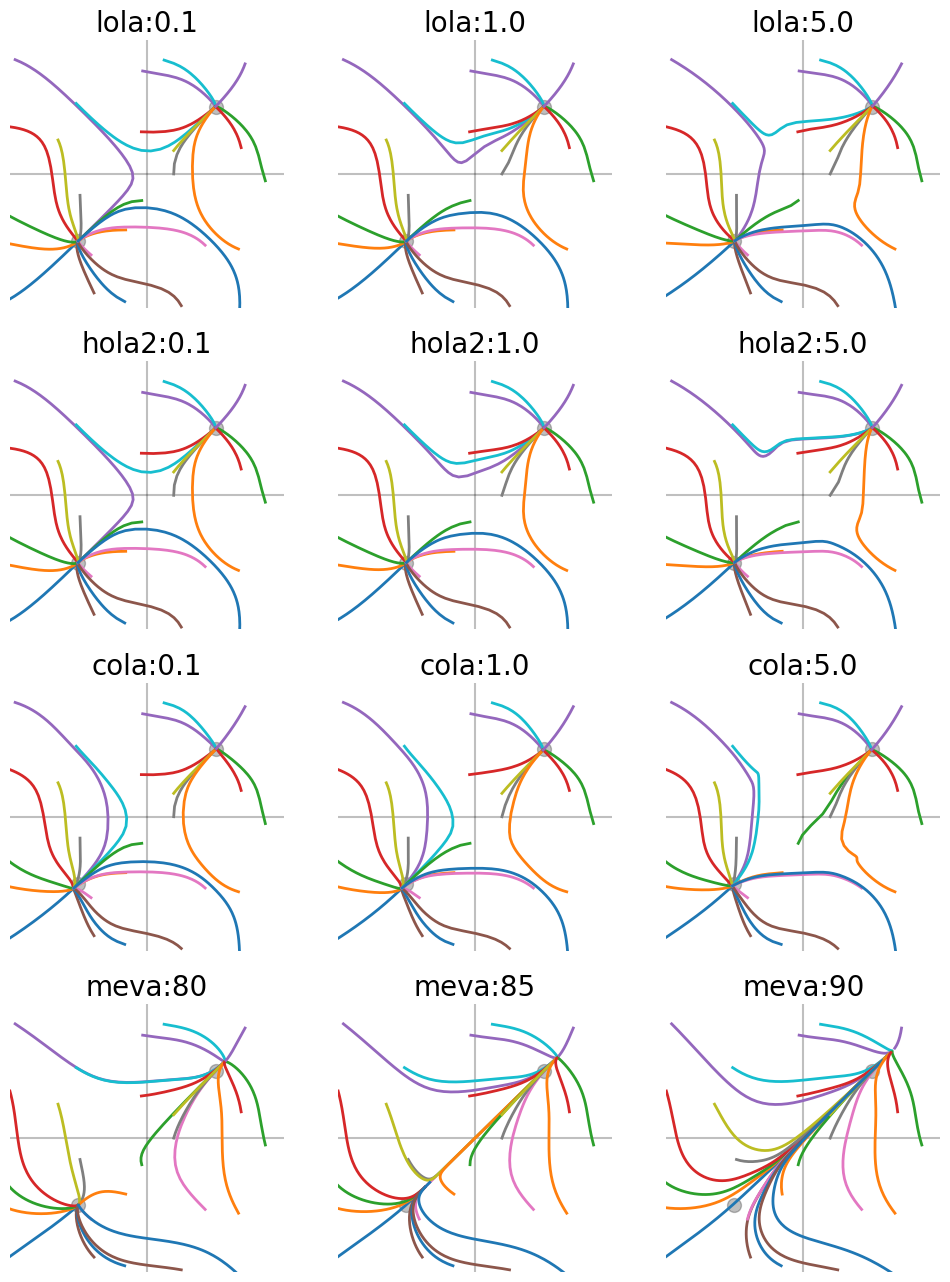

In [32]:
def plot_trails(trace, ax, title=None):
  # plot axis lines and a circle at good/bad solutions
  ax.axhline(0., color="k", alpha=0.25); ax.axvline(0., color="k", alpha=0.25)
  ax.scatter(*goodx[:,None], c="k", alpha=0.25, marker="o", s=100)
  ax.scatter(*badx[:,None], c="k", alpha=0.25, marker="o", s=100)

  ax.plot(trace[..., 0].T, trace[..., 1].T, linewidth=2)
  if title is not None:
    ax.set_title(title, fontsize=20)
  ax.set_xlim((-10, +10)); ax.set_ylim((-10, +10))
  ax.set_axis_off()

subplots([[partial(plot_trails, trails[key], title=key) for key in "lola:0.1 lola:1.0 lola:5.0".split()],
          [partial(plot_trails, trails[key], title=key) for key in "hola2:0.1 hola2:1.0 hola2:5.0".split()],
          #[partial(plot_trails, trails[key], title=key) for key in "hola3:0.1 hola3:1.0 hola3:5.0".split()],
          [partial(plot_trails, trails[key], title=key) for key in "cola:0.1 cola:1.0 cola:5.0".split()],
          [partial(plot_trails, trails[key], title=key) for key in "meva:80 meva:85 meva:90".split()],
          #[partial(plot_trails, trails[key], title=key) for key in "meva:80 meva:90 meva:95".split()],
          ],
         subplot_wh_hint=(4, 4))
pass

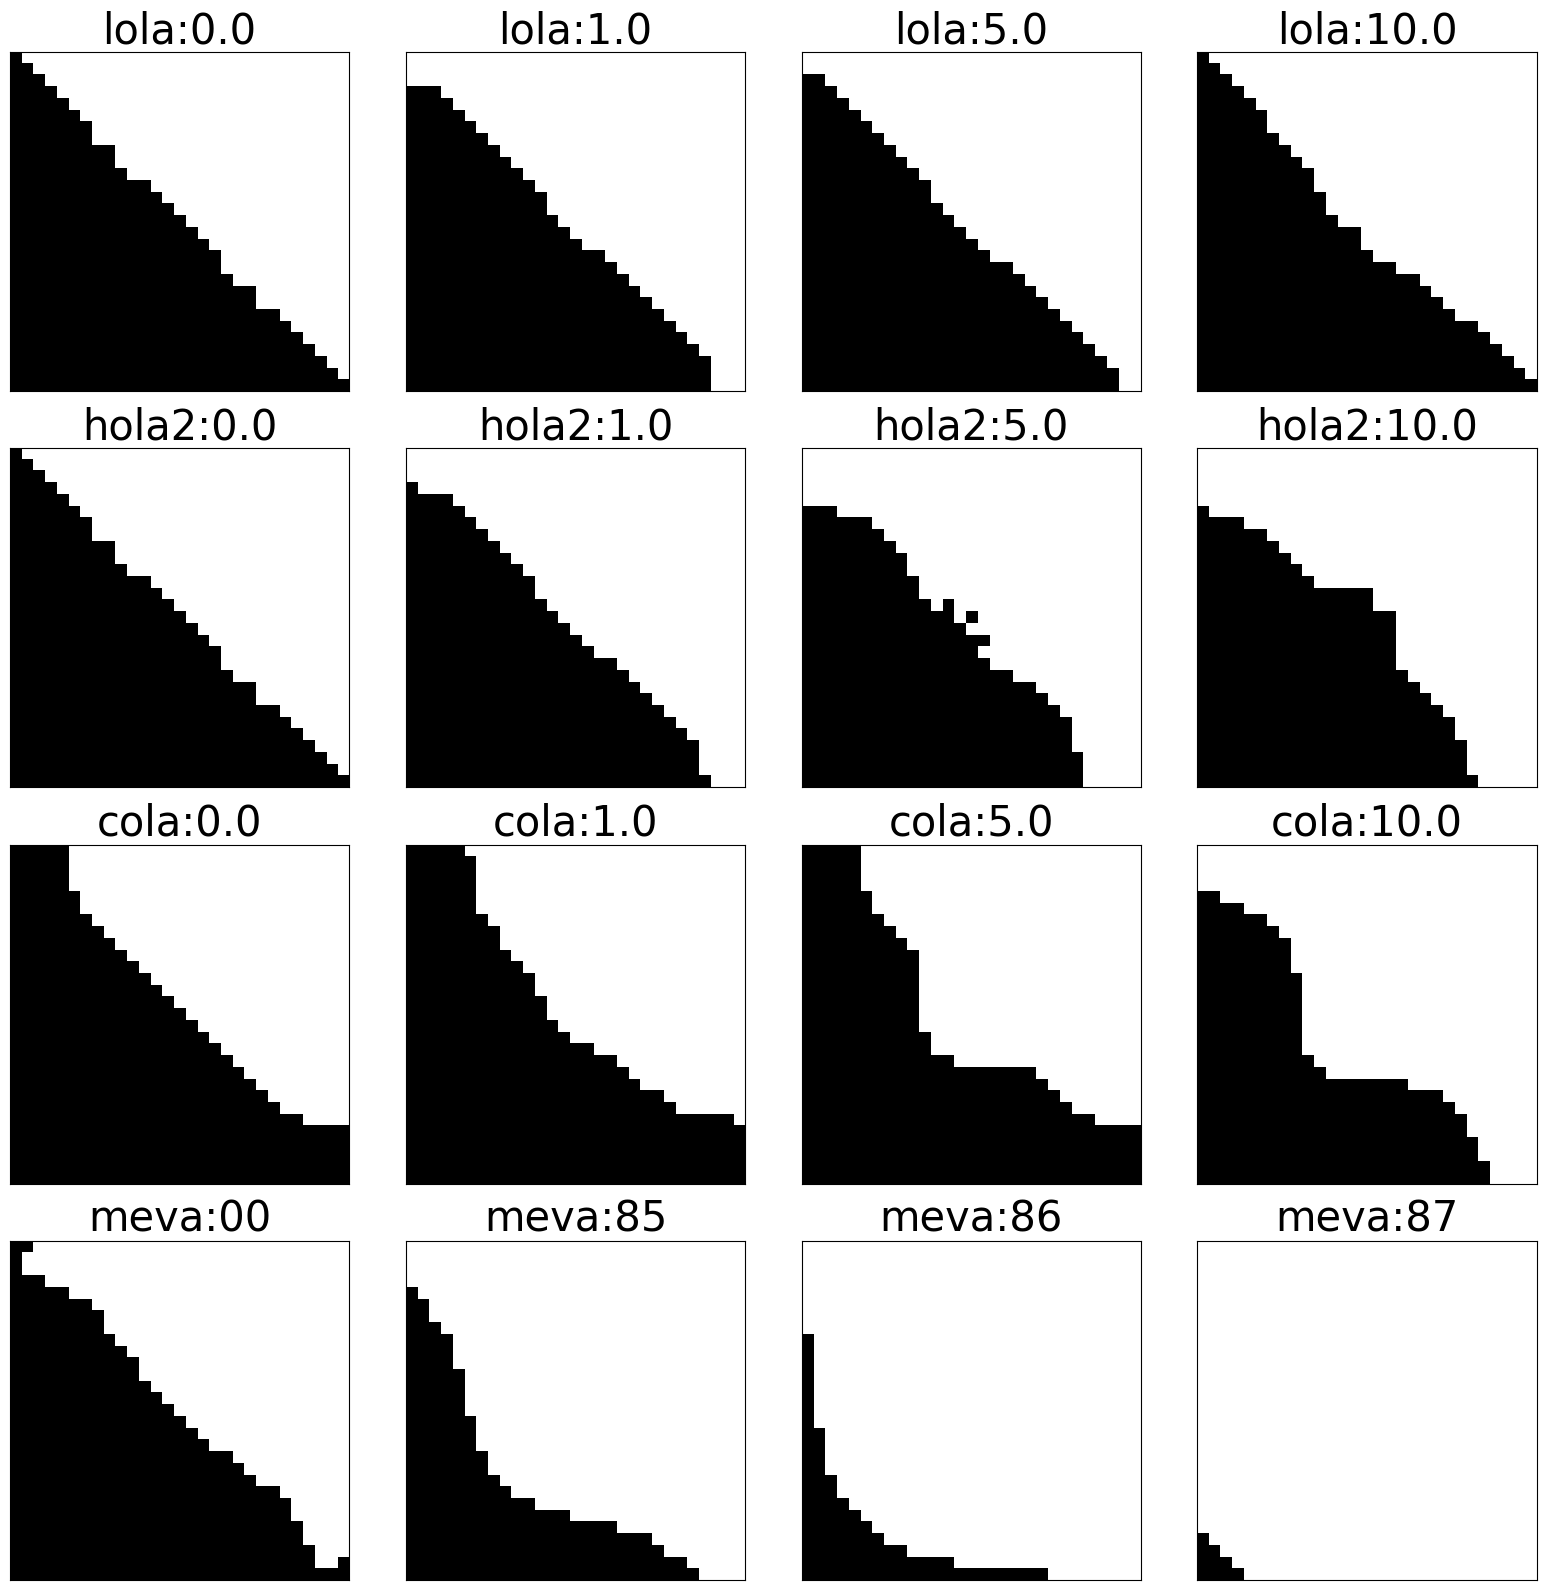

In [33]:
def plot_grid_endpoints(xs, ax, title=None, **kwargs):
  if False:
    fs = jax.vmap(jax.vmap(f))(xs)
    ys = fs.min(axis=-1)  # how well-off is the worst-off player?
    ax.imshow(ys, cmap="RdBu_r", interpolation="none", origin="lower", vmin=-8, vmax=+8, **kwargs)
  else:
    ys = (xs>0).all(axis=-1)  # show whether players ended up in upper right quadrant
    ax.imshow(ys, cmap="gray", interpolation="none", origin="lower", vmin=0, vmax=1, **kwargs)
  if title is not None:
    ax.set_title(title, fontsize=30)#, labelpad=20)
  #ax.set_axis_off()
  ax.tick_params(axis="both", which="both",
                 bottom=False, top=False, left=False, right=False,
                 labelleft=False, labelbottom=False)

subplots([[partial(plot_grid_endpoints, endpoints[key], title=key) for key in "lola:0.0 lola:1.0 lola:5.0 lola:10.0".split()],
          [partial(plot_grid_endpoints, endpoints[key], title=key) for key in "hola2:0.0 hola2:1.0 hola2:5.0 hola2:10.0".split()],
          #[partial(plot_grid_endpoints, endpoints[key], title=key) for key in "hola3:0.0 hola3:1.0 hola3:5.0 hola3:10.0".split()],
          [partial(plot_grid_endpoints, endpoints[key], title=key) for key in "cola:0.0 cola:1.0 cola:5.0 cola:10.0".split()],
          [partial(plot_grid_endpoints, endpoints[key], title=key) for key in "meva:00 meva:85 meva:86 meva:87".split()],
          #[partial(plot_grid_endpoints, endpoints[key], title=key) for key in "meva:00 meva:80 meva:90 meva:95".split()],
          ],
         subplot_wh_hint=(4, 4))
plt.tight_layout()

pass